In [1]:
import zipfile, os
import glob
import cv2
import matplotlib.pyplot as plt
!pip install tqdm
from tqdm import tqdm
import numpy as np
from skimage.restoration import denoise_nl_means
from skimage.filters import unsharp_mask

In [3]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Semester2/ComputerVision/Data.zip"


Mounted at /content/drive


In [4]:
#Extract ZIP
dataset = "/content/drive/My Drive/Semester2/ComputerVision/Dataset"

# Ekstrak ZIP
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(dataset)

# Cek isi folder hasil ekstraksi
os.listdir(dataset)

['PNEUMONIA']

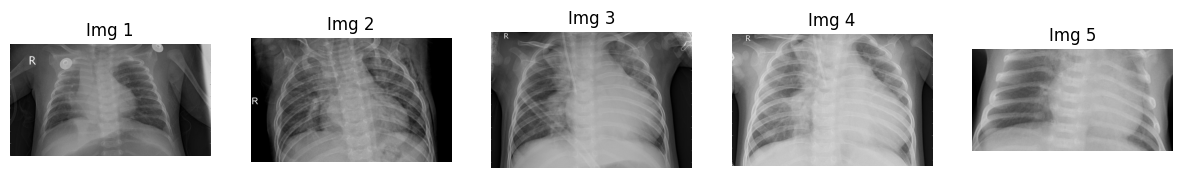

In [5]:
pneumonia_path = os.path.join(dataset, "PNEUMONIA")

# Ambil 5 file pertama
files = os.listdir(pneumonia_path)[:5]

plt.figure(figsize=(15,5))
for i, file_name in enumerate(files):
    img_path = os.path.join(pneumonia_path, file_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Img " + str(i+1))
    plt.axis("off")

plt.show()

In [6]:
def load_all_images(folder):
    images, paths = [], []
    for root, dirs, files in os.walk(folder):
        for file in files:
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                paths.append(img_path)
    return images, paths

images, img_paths = load_all_images(dataset)
print(f"Total gambar: {len(images)}")

Total gambar: 1000


CROPPING dan Resize

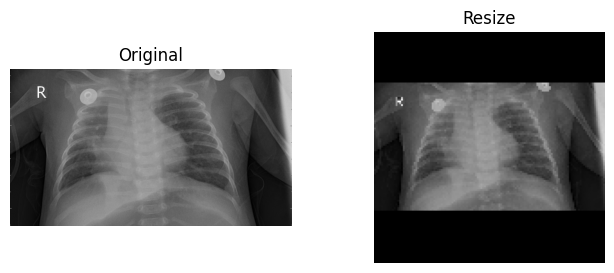

In [12]:
def resize_with_padding(img, size=(128,128)):
    target_w, target_h = size
    h, w = img.shape[:2]

    # Hitung scale faktor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize gambar sesuai scale
    resized = cv2.resize(img, (new_w, new_h))

    # Buat canvas hitam
    if len(img.shape) == 2:  # grayscale
        result = np.zeros((target_h, target_w), dtype=img.dtype)
    else:  # RGB
        result = np.zeros((target_h, target_w, 3), dtype=img.dtype)

    # Hitung posisi tengah
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2

    # Tempel gambar ke canvas
    result[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    return result
images_resized = [resize_with_padding(img) for img in images]

# Tampilkan contoh
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(images[0], cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(images_resized[0], cmap="gray"); plt.title("Resize"); plt.axis("off")
plt.show()


Denoising

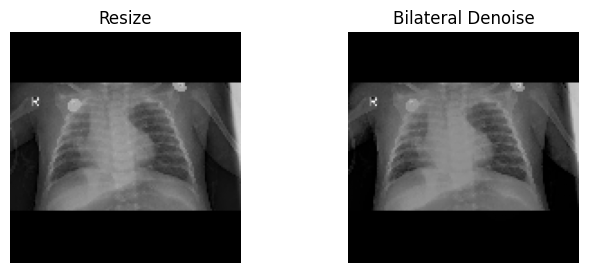

In [8]:
from skimage.restoration import denoise_bilateral

def bilateral_denoise(img):
    img_norm = img.astype("float32") / 255.0

    # Terapkan bilateral filter
    img_dn = denoise_bilateral(
        img_norm,
        sigma_color=0.05,
        sigma_spatial=15,
        channel_axis=None       )

    # Kembalikan ke uint8
    return (img_dn * 255).astype("uint8")

# Terapkan ke semua gambar hasil resize
images_bilateral = [bilateral_denoise(img) for img in images_resized]

# Tampilkan contoh sebelum & sesudah
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(images_resized[0], cmap="gray")
plt.title("Resize")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(images_bilateral[0], cmap="gray")
plt.title("Bilateral Denoise")
plt.axis("off")

plt.show()


CLAHE

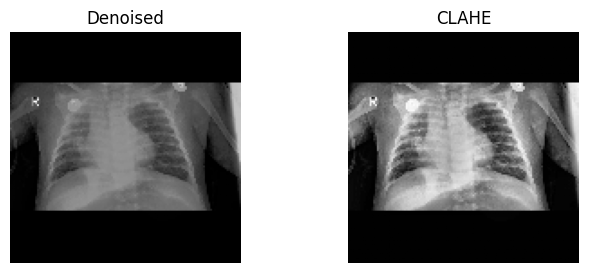

In [9]:
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

# Terapkan CLAHE pada hasil bilateral denoise
images_clahe = [apply_clahe(img) for img in images_bilateral]

# Tampilkan contoh
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(images_bilateral[0], cmap="gray")
plt.title("Denoised")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(images_clahe[0], cmap="gray")
plt.title("CLAHE")
plt.axis("off")

plt.show()


Sharpening

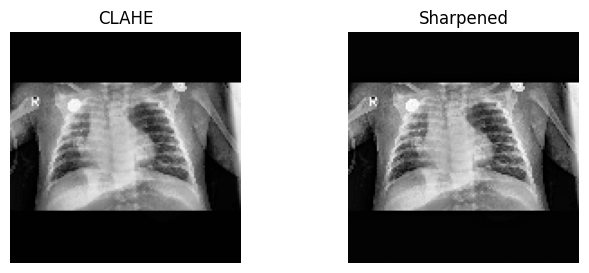

In [16]:
def sharpen(img, radius=1.0, amount=0.3):
    img_sharp = unsharp_mask(img, radius=radius, amount=amount, preserve_range=True)
    if img_sharp.max() <= 1:
        img_sharp = (img_sharp * 255).astype("uint8")
    else:
        img_sharp = np.clip(img_sharp, 0, 255).astype("uint8")

    return img_sharp

images_sharp = [sharpen(img, radius=1.0, amount=0.3) for img in images_clahe]

# Tampilkan plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(images_clahe[0], cmap="gray"); plt.title("CLAHE"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(images_sharp[0], cmap="gray"); plt.title("Sharpened"); plt.axis("off")
plt.show()



Perbandingan Keseluruhan

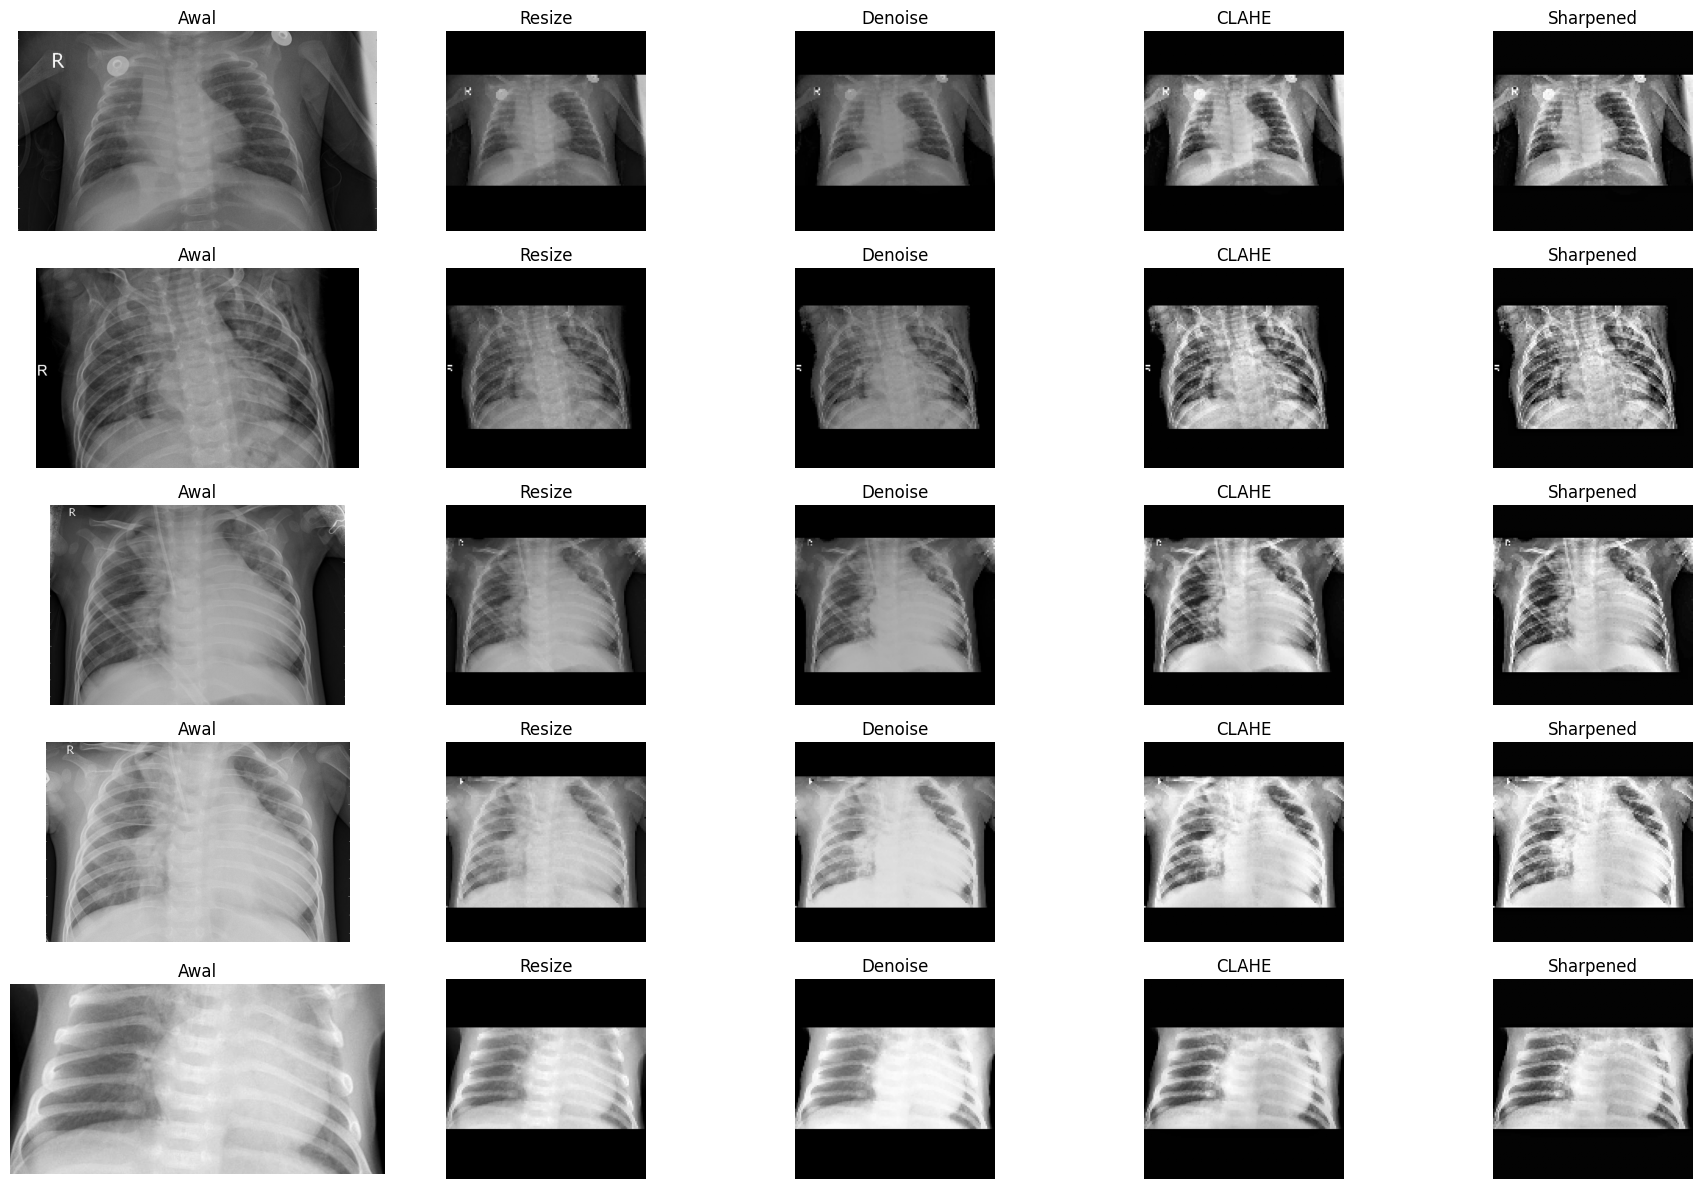

In [15]:
plt.figure(figsize=(18,12))
for i in range(5):
  plt.subplot(5, 5, i*5+1); plt.imshow(images[i], cmap="gray"); plt.title("Awal"); plt.axis("off")
  plt.subplot(5, 5, i*5+2); plt.imshow(images_resized[i], cmap="gray"); plt.title("Resize"); plt.axis("off")
  plt.subplot(5, 5, i*5+3); plt.imshow(images_bilateral[i], cmap="gray"); plt.title("Denoise"); plt.axis("off")
  plt.subplot(5, 5, i*5+4); plt.imshow(images_clahe[i], cmap="gray"); plt.title("CLAHE"); plt.axis("off")
  plt.subplot(5, 5, i*5+5); plt.imshow(images_sharp[i], cmap="gray"); plt.title("Sharpened"); plt.axis("off")
plt.tight_layout()
plt.show()